# Introduction

QA plots for the generic tracking performance

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
import os.path

# readme file of the macros, available if run under JenkinsCI
# https://github.com/sPHENIX-Collaboration/utilities/blob/master/jenkins/built-test/test-tracking-qa.sh 

macro_markdown = 'Fun4All-macros-README.md'


if os.path.isfile(macro_markdown) :
    with open(macro_markdown, 'r') as file:
        display(Markdown(file.read()))

[//]: # (This section starts with a 2nd level heading and get embedded in the result QA report at https://github.com/sPHENIX-Collaboration/QA-gallery/tree/QA-tracking-high-occupancy)

## Tracking QA at high occupancy

High occupancy tracking QA consists full tracker + reconstruction of events with 76 $\pi^+$, and 76 $\pi^-$ in a $\Delta\eta \times \Delta\phi = 0.5 \times 0.5$ window. In this small window, we would like to emulate the occupancy for 0-10% AuAu 200 GeV $\delta N_{Ch}/\delta\eta = 609$ [DOI: 10.1103/PhysRevC.83.024913]. Beyond this window, six more high $p_T>60$ GeV$/c$ pions are added to help constraint 3D vertex. 

Please note the calorimeters are disabled to improve execution speed, which also removed some of the correlated albedo background for the tracker. 

The source code of the macro can be found at https://github.com/sPHENIX-Collaboration/macros/tree/QA-tracking-high-occupancy or [comparing it to the master branch](https://github.com/sPHENIX-Collaboration/macros/compare/QA-tracking-high-occupancy?expand=1).



## `pyROOT` env check

In [4]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/var/lib/jenkins/workspace/sPHENIX/Build-Master-gcc8/build/new/install.1`

## Plotting source code

In [5]:
import subprocess

try:
    git_url = \
        subprocess.run(['git','remote','get-url','origin'], stdout=subprocess.PIPE)\
        .stdout.decode('utf-8').strip()\
        .replace('git@github.com:','https://github.com/')

    display(Markdown(f"View the source code repository at {git_url}"))
except: # catch *all* exceptions
    #     well do nothing
    pass

View the source code repository at https://github.com/sPHENIX-Collaboration/QA-gallery.git

## JenkinsCI information (if available)

In [6]:
display(Markdown('Some further details about the QA run, if executed under the Jenkins CI:'))

checkrun_repo_commit = os.getenv("checkrun_repo_commit")
if checkrun_repo_commit is not None:
    display(Markdown(f"* The commit being checked is {checkrun_repo_commit}"))
        
ghprbPullLink = os.getenv("ghprbPullLink")
if ghprbPullLink is not None:
    display(Markdown(f"* Link to the pull request: {ghprbPullLink}"))

BUILD_URL =  os.getenv("BUILD_URL")
if BUILD_URL is not None:
    display(Markdown(f"* Link to the build: {BUILD_URL}"))

git_url_macros =  os.getenv("git_url_macros")
sha_macros =  os.getenv("sha_macros")
if git_url_macros is not None:
    display(Markdown(f"* Git repo for macros: {git_url_macros} , which merges `{sha_macros}` and the QA tracking branch"))

RUN_ARTIFACTS_DISPLAY_URL = os.getenv("RUN_ARTIFACTS_DISPLAY_URL")
if RUN_ARTIFACTS_DISPLAY_URL is not None:
    display(Markdown(f"* Download the QA ROOT files: {RUN_ARTIFACTS_DISPLAY_URL}"))

JENKINS_URL  = os.getenv("JENKINS_URL")
if JENKINS_URL is not None:
    display(Markdown(f"Automatically generated by [sPHENIX Jenkins continuous integration]({JENKINS_URL}) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)"))

Some further details about the QA run, if executed under the Jenkins CI:

* The commit being checked is sPHENIX-Collaboration/coresoftware/dee8b26d746764678218bc8d55fdb95e3a5c4f3b

* Link to the build: https://web.sdcc.bnl.gov/jenkins-sphenix/job/sPHENIX/job/test-tracking-high-occupancy-qa/1566/

* Git repo for macros: https://github.com/sPHENIX-Collaboration/macros.git , which merges `*/master` and the QA tracking branch

* Download the QA ROOT files: https://web.sdcc.bnl.gov/jenkins-sphenix/job/sPHENIX/job/test-tracking-high-occupancy-qa/1566/display/redirect?page=artifacts

Automatically generated by [sPHENIX Jenkins continuous integration](https://web.sdcc.bnl.gov/jenkins-sphenix/) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)


# Initialization

In [7]:
%%cpp -d

#include "QA_Draw_Utility.C"

#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [8]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");

// test sPHENIX lib load
// gSystem->Load("libg4eval.so");

// test libs
// gSystem->ListLibraries();

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [9]:

qa_file_name_new = os.getenv("qa_file_name_new")
if qa_file_name_new is None:
    qa_file_name_new = "G4sPHENIX_test-tracking-low-occupancy-qa_Event100_Sum10_qa.root"
    display(Markdown(f"`qa_file_name_new` env not set. use the default `qa_file_name_new={qa_file_name_new}`"))

qa_file_name_ref = os.getenv("qa_file_name_ref")
if qa_file_name_ref is None:
    qa_file_name_ref = "reference/G4sPHENIX_test-tracking-low-occupancy-qa_Event100_Sum10_qa.root"
    display(Markdown(f"`qa_file_name_ref` env not set. use the default `qa_file_name_ref={qa_file_name_ref}`"))
elif qa_file_name_ref == 'None':
    qa_file_name_ref = None
    display(Markdown(f"`qa_file_name_ref` = None and we are set to not to use the reference histograms"))
    


In [10]:
# qa_file_new = ROOT.TFile.Open(qa_file_name_new);

# assert qa_file_new.IsOpen()
# qa_file_new.ls()
display(Markdown(f"Opening QA file at `{qa_file_name_new}`"))
ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_new = new TFile(\"{qa_file_name_new}\");")
ROOT.gInterpreter.ProcessLine(f"const char * qa_file_name_new = \"{qa_file_name_new}\";")

if qa_file_name_ref is not None:
#     qa_file_ref = ROOT.TFile.Open(qa_file_name_ref);

#     assert qa_file_ref.IsOpen()
    display(Markdown(f"Opening QA reference file at `{qa_file_name_ref}`"))
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = new TFile(\"{qa_file_name_ref}\");")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = \"{qa_file_name_ref}\";")
else:
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = nullptr;")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = nullptr;")


Opening QA file at `G4sPHENIX_test-tracking_Event50_Sum10_qa.root`

Opening QA reference file at `reference/G4sPHENIX_test-tracking_Event50_Sum10_qa.root`

In [11]:
%%cpp

if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

// list inputs histograms if needed
// qa_file_new ->ls();

//TFile *qa_file_ref = NULL;
//if (qa_file_name_ref)
//{
//    qa_file_ref = new TFile(qa_file_name_ref);
//  
//    if (qa_file_ref == nullptr) 
//    {
//        cout <<"Error, can not open QA root file"<<qa_file_name_ref<<endl;
//        exit(1);
//    }
//}

# Truth matched efficiency and $p_T$ resolution

## Match truth track to reco tracks

Reco track matched with truth track. Please note the efficiency only require truth-reco matching in unique pairs, no cut on the reco quality is required, as defined in [`QAG4SimulationTracking::process_event(PHCompositeNode * )`](https://sphenix-collaboration.github.io/doxygen/de/dbf/classQAG4SimulationTracking.html#ac2aeab5238fcf828f70c61b4976b57fe)

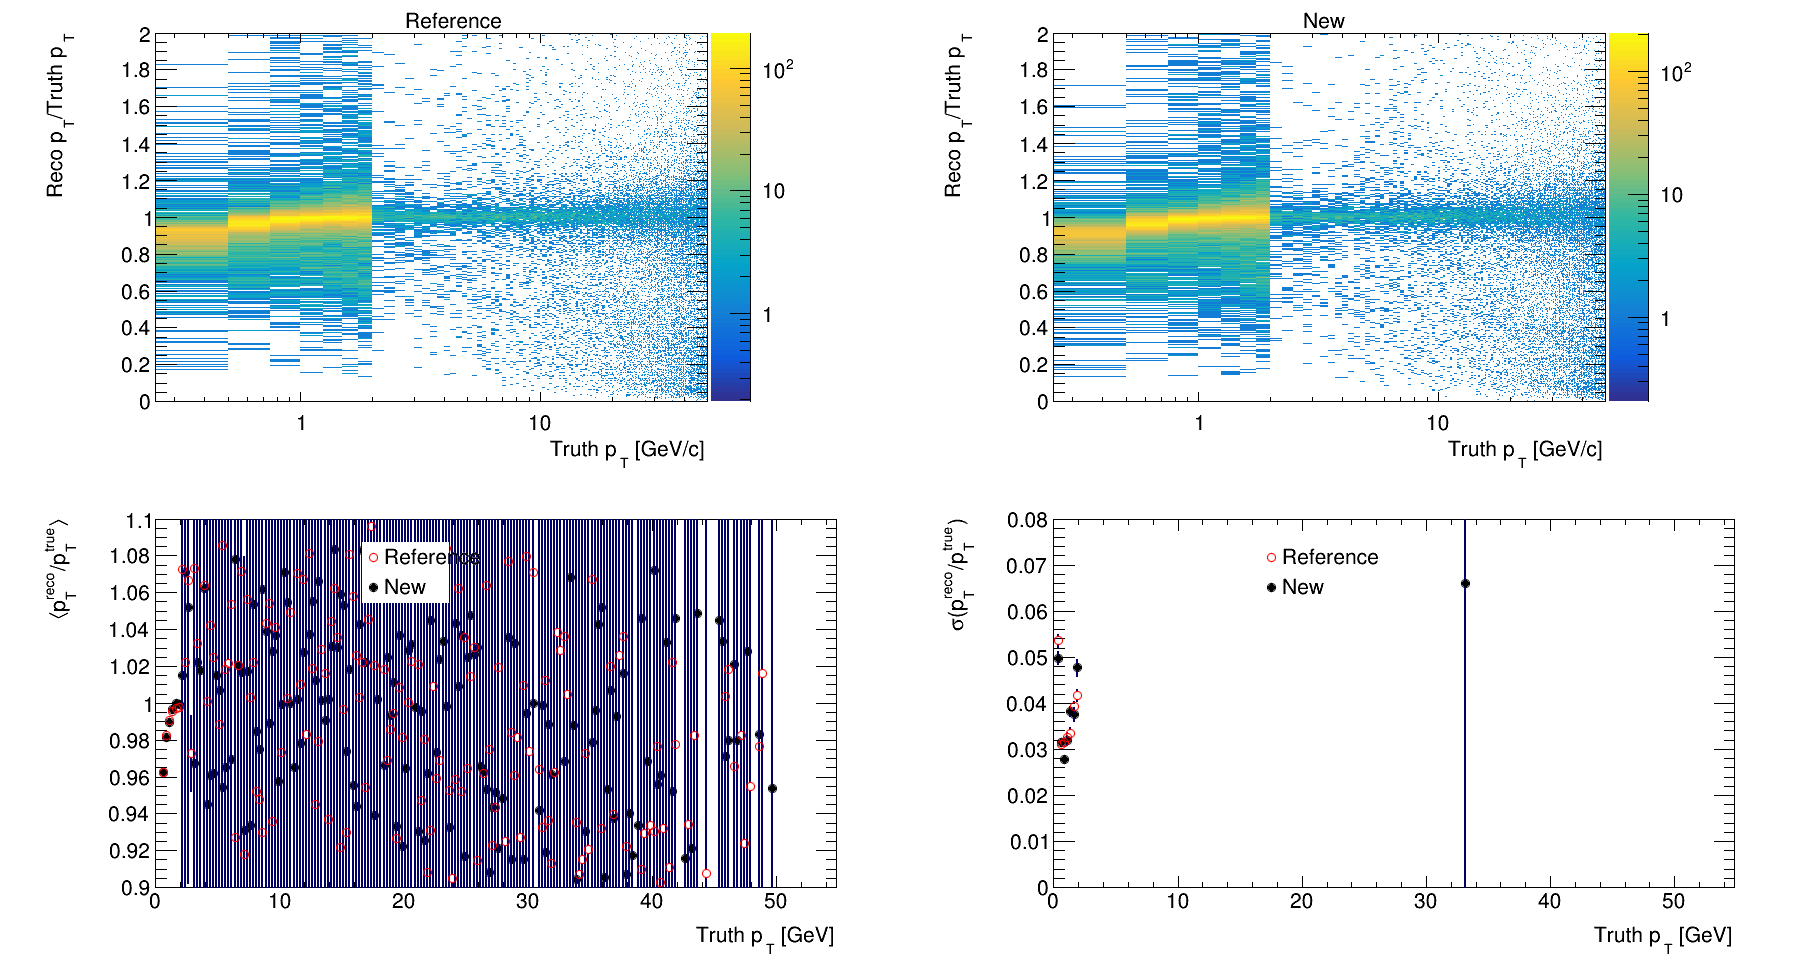

In [12]:
%%cpp
{
    const char *hist_name_prefix = "QAG4SimulationTracking";
    TString prefix = TString("h_") + hist_name_prefix + TString("_");
    
    TCanvas *rawResCan = new TCanvas(TString("QA_Draw_pTResolution") + TString("_") + hist_name_prefix,
                                     TString("QA_Draw_pTResolution") + TString("_") + hist_name_prefix,
                                     1800,1000);
    rawResCan->Divide(2,2);
    
    TH2F *h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new =
        (TH2F *)qa_file_new->GetObjectChecked(prefix + "pTRecoGenRatio_pTGen",
                                             "TH2");
    assert(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new);
    
    h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new->SetDirectory(nullptr);
    
    TGraphErrors *newScale = FitResolution(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new, false, 1);
    TGraphErrors *newRes = FitResolution(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new, false, 2);
    newScale->SetMarkerStyle(20);
    newScale->SetMarkerColor(kBlack);
    newScale->SetMarkerSize(1.0);
    newRes->SetMarkerStyle(20);
    newRes->SetMarkerColor(kBlack);
    newRes->SetMarkerSize(1.0);
    
    rawResCan->cd(3);
    newScale->GetXaxis()->SetTitle("Truth p_{T} [GeV]");
    newScale->GetYaxis()->SetTitle("#LTp_{T}^{reco}/p_{T}^{true}#GT");
    newScale->GetYaxis()->SetRangeUser(0.9,1.1);
    newScale->Draw("ap");
    
    rawResCan->cd(4);
    newRes->GetXaxis()->SetTitle("Truth p_{T} [GeV]");
    newRes->GetYaxis()->SetTitle("#sigma(p_{T}^{reco}/p_{T}^{true})");
    newRes->GetYaxis()->SetRangeUser(0,0.08);
    newRes->Draw("ap");
    
    rawResCan->cd(2);
    gPad->SetRightMargin(0.2);
    gPad->SetLogx();
    gPad->SetLogz();
    h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new->SetTitle("New pT Spectrum");
    h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_new->Draw("colz");
    
    TLatex newl; 
    newl.SetTextSize(0.05); 
    newl.SetNDC();
    newl.SetTextColor(kBlack);
    newl.DrawLatex(0.45,0.96,"New");
    
    if (qa_file_ref) {
      TH2F *h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref =
          (TH2F *)qa_file_ref->GetObjectChecked(prefix + "pTRecoGenRatio_pTGen",
                                               "TH2");
      assert(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref);
      h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref->SetDirectory(nullptr);
        
      TGraphErrors *refScale = FitResolution(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref, false, 1);
      TGraphErrors *refRes = FitResolution(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref, false, 2);
      refScale->SetMarkerStyle(24);
      refScale->SetMarkerColor(kRed);
      refScale->SetMarkerSize(1.0);
      refRes->SetMarkerStyle(24);
      refRes->SetMarkerColor(kRed);
      refRes->SetMarkerSize(1.0);
        
      TLegend *ptresleg = new TLegend(0.4,0.77,0.5,0.9);
      ptresleg->AddEntry(refScale,"Reference","P");
      ptresleg->AddEntry(newScale,"New","P"); 
        
      rawResCan->cd(3);
      refScale->Draw("psame");
      ptresleg->Draw("same");
       
      rawResCan->cd(4);
      refRes->Draw("psame");
      ptresleg->Draw("same"); 
        
      rawResCan->cd(1);
  
      gPad->SetRightMargin(0.2);
      gPad->SetLogx();
      gPad->SetLogz();
      h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref->SetTitle("Reference pT Spectrum");
      h_QAG4SimulationTracking_pTRecoGenRatio_pTGen_ref->Draw("colz");
      TLatex refl; 
      refl.SetTextSize(0.05); 
      refl.SetNDC();
      refl.SetTextColor(kBlack);
      refl.DrawLatex(0.45,0.96,"Reference");
  
    }
        
    rawResCan->Draw();
    
   
}




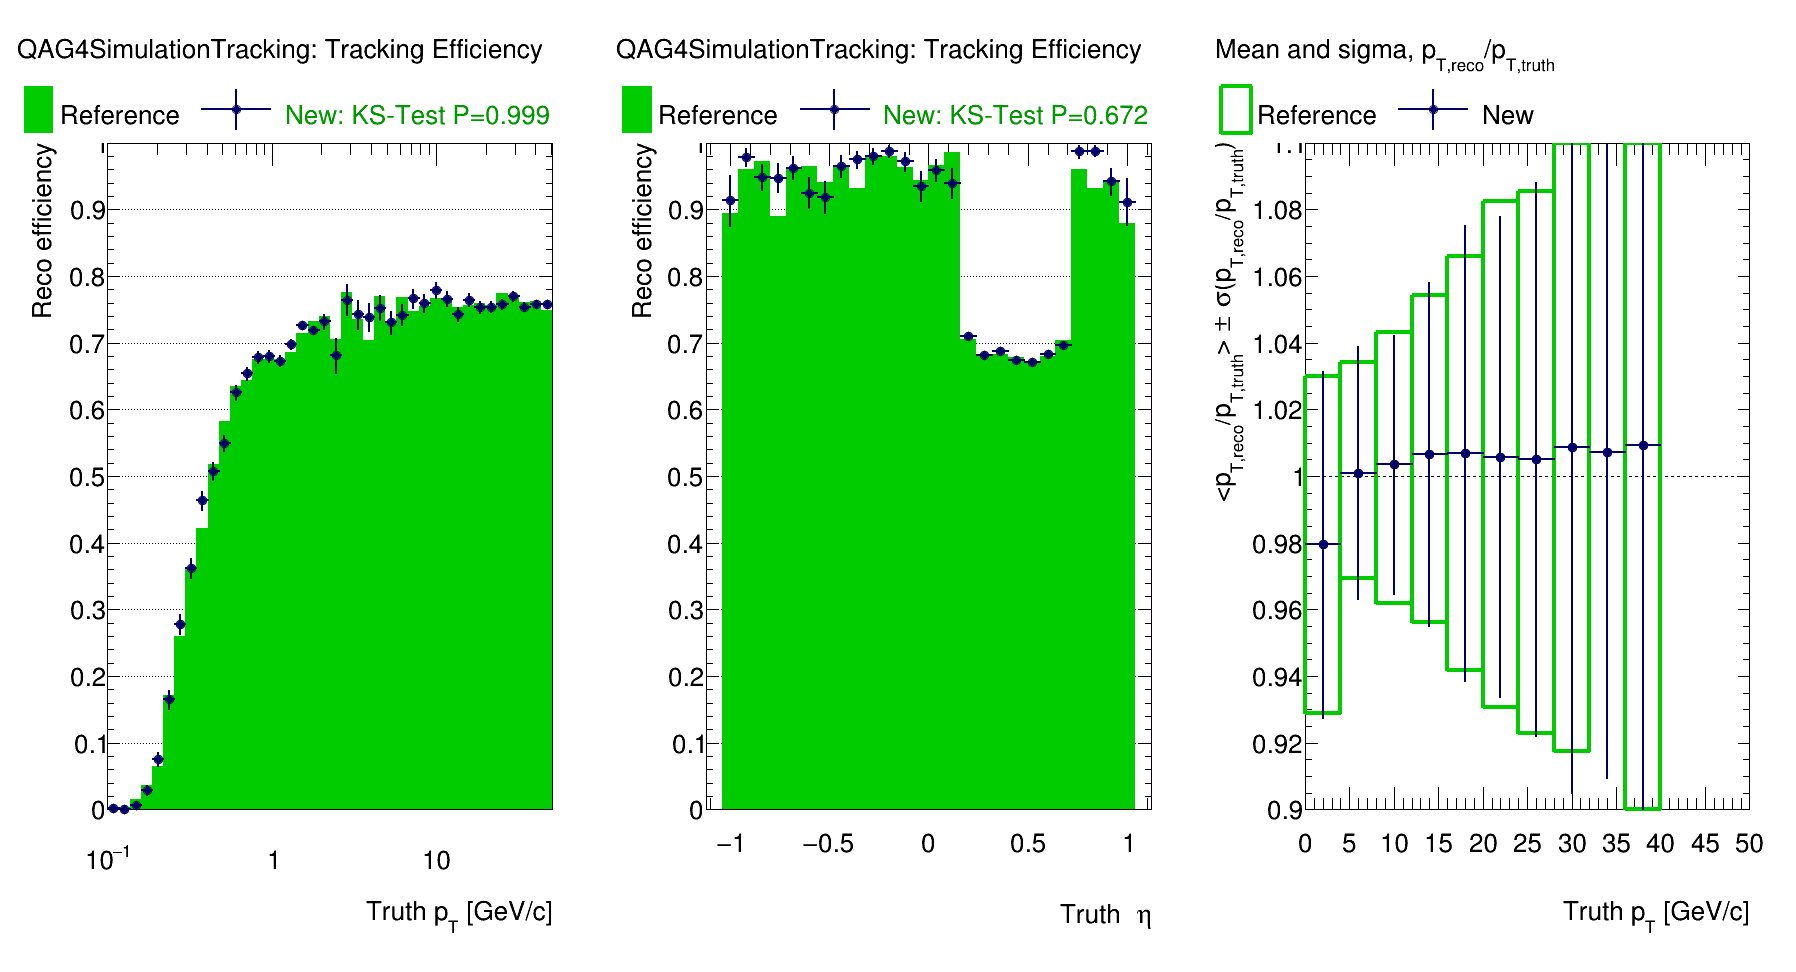

In [13]:
%%cpp

{
  //base histogram from the reco module name 
  const char *hist_name_prefix = "QAG4SimulationTracking";
  TString prefix = TString("h_") + hist_name_prefix + TString("_");
    
  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;

  TCanvas *c1 = new TCanvas(TString("QA_Draw_Tracking_TruthMatchingOverview") +
                                TString("_") + hist_name_prefix,
                            TString("QA_Draw_Tracking_TruthMatchingOverview") +
                                TString("_") + hist_name_prefix,
                            1800, 1000);
  c1->Divide(3, 1);
  int idx = 1;
  TPad *p;

  {
    static const int nrebin = 5;

    p = (TPad *)c1->cd(idx++);
    c1->Update();
    p->SetLogx();
    p->SetGridy();

    TH1 *h_pass =
        (TH1 *)qa_file_new->GetObjectChecked(prefix + "nReco_pTGen", "TH1");
    TH1 *h_norm =
        (TH1 *)qa_file_new->GetObjectChecked(prefix + "nGen_pTGen", "TH1");
    assert(h_norm);
    assert(h_pass);
      
      h_norm->SetDirectory(nullptr);
      h_pass->SetDirectory(nullptr);

    h_norm->Rebin(nrebin);
    h_pass->Rebin(nrebin);

    TH1 *h_ratio = GetBinominalRatio(h_pass, h_norm);

    //    h_ratio->GetXaxis()->SetRangeUser(min_Et, max_Et);
    h_ratio->GetYaxis()->SetTitle("Reco efficiency");
    h_ratio->GetYaxis()->SetRangeUser(-0, 1.);

    TH1 *h_ratio_ref = NULL;
    if (qa_file_ref) {
      TH1 *h_pass =
          (TH1 *)qa_file_ref->GetObjectChecked(prefix + "nReco_pTGen", "TH1");
      TH1 *h_norm =
          (TH1 *)qa_file_ref->GetObjectChecked(prefix + "nGen_pTGen", "TH1");
      assert(h_norm);
      assert(h_pass);
      h_norm->SetDirectory(nullptr);
      h_pass->SetDirectory(nullptr);
      h_norm->Rebin(nrebin);
      h_pass->Rebin(nrebin);
      h_ratio_ref = GetBinominalRatio(h_pass, h_norm);
    }

    h_ratio->SetTitle(TString(hist_name_prefix) + ": Tracking Efficiency");

    DrawReference(h_ratio, h_ratio_ref, false);
  }

  {
    static const int nrebin = 4;

    p = (TPad *)c1->cd(idx++);
    c1->Update();
    // p->SetLogx();
    p->SetGridy();

    TH1 *h_pass =
        (TH1 *)qa_file_new->GetObjectChecked(prefix + "nReco_etaGen", "TH1");
    TH1 *h_norm =
        (TH1 *)qa_file_new->GetObjectChecked(prefix + "nGen_etaGen", "TH1");
    assert(h_norm);
    assert(h_pass);

      h_norm->SetDirectory(nullptr);
      h_pass->SetDirectory(nullptr);
    h_norm->Rebin(nrebin);
    h_pass->Rebin(nrebin);

    TH1 *h_ratio = GetBinominalRatio(h_pass, h_norm);

    h_ratio->GetXaxis()->SetRangeUser(-1.1, 1.1);
    h_ratio->GetYaxis()->SetTitle("Reco efficiency");
    h_ratio->GetYaxis()->SetRangeUser(-0, 1.);

    TH1 *h_ratio_ref = NULL;
    if (qa_file_ref) {
      TH1 *h_pass =
          (TH1 *)qa_file_ref->GetObjectChecked(prefix + "nReco_etaGen", "TH1");
      TH1 *h_norm =
          (TH1 *)qa_file_ref->GetObjectChecked(prefix + "nGen_etaGen", "TH1");
      assert(h_norm);
      assert(h_pass);
      h_norm->SetDirectory(nullptr);
      h_pass->SetDirectory(nullptr);
      h_norm->Rebin(nrebin);
      h_pass->Rebin(nrebin);
      h_ratio_ref = GetBinominalRatio(h_pass, h_norm);
    }

    h_ratio->SetTitle(TString(hist_name_prefix) + ": Tracking Efficiency");

    DrawReference(h_ratio, h_ratio_ref, false);
  }

  {
    p = (TPad *)c1->cd(idx++);
    c1->Update();
    //    p->SetLogx();
    TH1 *frame = p->DrawFrame(0, .9, 50, 1.1,
                              "Mean and sigma, p_{T,reco}/p_{T,truth};Truth p_{T} [GeV/c];<p_{T,reco}/p_{T,truth}> #pm #sigma(p_{T,reco}/p_{T,truth})");
    //gPad->SetLeftMargin(.2);
    gPad->SetTopMargin(-1);
    frame->GetYaxis()->SetTitleOffset(1.7);
    //TLine *l = new TLine(0, 1, 50, 1);
    //l->SetLineColor(kGray);
    //l->Draw();
    HorizontalLine( gPad, 1 )->Draw();

    TH2 *h_QAG4SimulationTracking_pTRecoGenRatio_pTGen =
        (TH2 *)qa_file_new->GetObjectChecked(prefix + "pTRecoGenRatio_pTGen",
                                             "TH2");
    assert(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen);

      h_QAG4SimulationTracking_pTRecoGenRatio_pTGen->SetDirectory(nullptr);
    h_QAG4SimulationTracking_pTRecoGenRatio_pTGen->Rebin2D(16, 1);
    TGraphErrors *ge_QAG4SimulationTracking_pTRecoGenRatio_pTGen =
        FitProfile(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen);
    ge_QAG4SimulationTracking_pTRecoGenRatio_pTGen->Draw("pe");
    ge_QAG4SimulationTracking_pTRecoGenRatio_pTGen->SetTitle(
        "Mean and sigma, p_{T,reco}/p_{T,truth}");

    TGraphErrors *h_ratio_ref = NULL;
    if (qa_file_ref) {
      TH2 *h_QAG4SimulationTracking_pTRecoGenRatio_pTGen =
          (TH2 *)qa_file_ref->GetObjectChecked(prefix + "pTRecoGenRatio_pTGen",
                                               "TH2");
      assert(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen);

      h_QAG4SimulationTracking_pTRecoGenRatio_pTGen->SetDirectory(nullptr);
      h_QAG4SimulationTracking_pTRecoGenRatio_pTGen->Rebin2D(16, 1);

      h_ratio_ref = FitProfile(h_QAG4SimulationTracking_pTRecoGenRatio_pTGen);
      ge_QAG4SimulationTracking_pTRecoGenRatio_pTGen->Draw("pe");
    }

    DrawReference(ge_QAG4SimulationTracking_pTRecoGenRatio_pTGen, h_ratio_ref,
                  true);
      
  }

  //SaveCanvas(c1,
  //           TString(qa_file_name_new) + TString("_") + TString(c1->GetName()),
  //           true);
    
  c1->Draw();
}

# $p_T$ resolution and lineshape

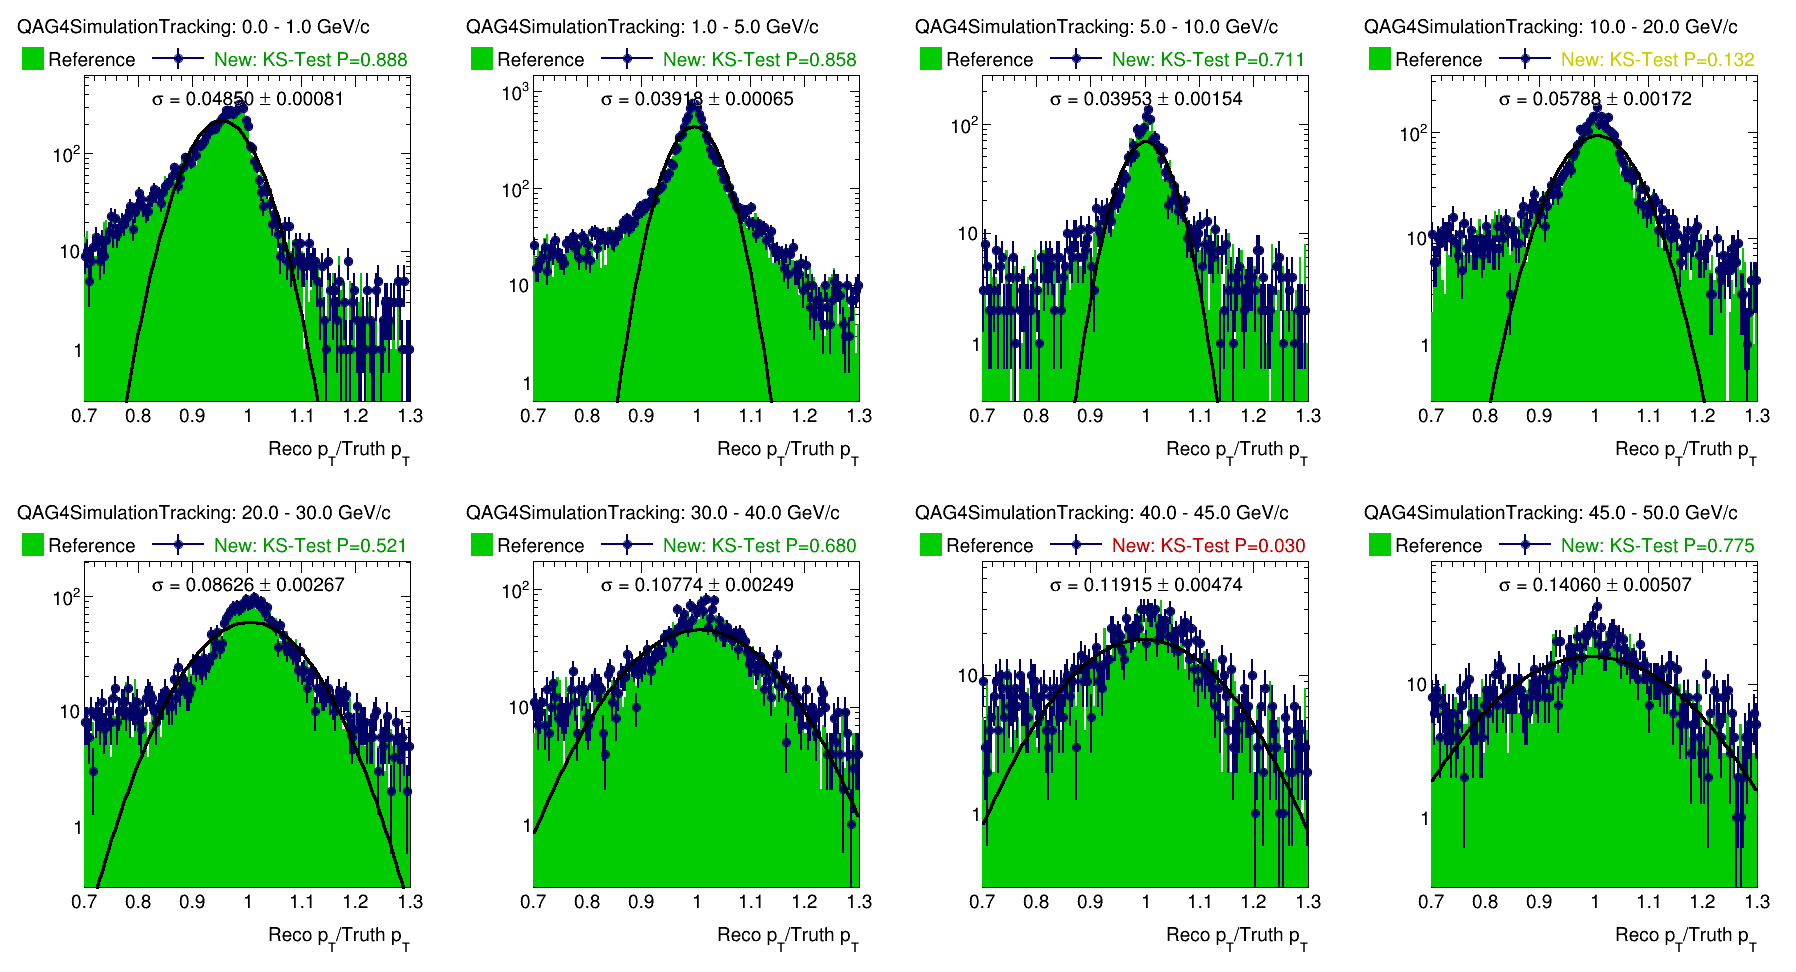

In [14]:
%%cpp

{
    const char *hist_name_prefix = "QAG4SimulationTracking";
    TString prefix = TString("h_") + hist_name_prefix + TString("_");
    
  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;
    
    
  TH2 *h_new = (TH2 *) qa_file_new->GetObjectChecked(
      prefix + TString("pTRecoGenRatio_pTGen"), "TH2");
  assert(h_new);

  //  h_new->Rebin(1, 2);
  //h_new->Sumw2();
  //  h_new->Scale(1. / Nevent_new);

  TH2 *h_ref = NULL;
  if (qa_file_ref)
  {
    h_ref = (TH2 *) qa_file_ref->GetObjectChecked(
        prefix + TString("pTRecoGenRatio_pTGen"), "TH2");
    assert(h_ref);

    //    h_ref->Rebin(1, 2);
    //h_ref->Sumw2();
    h_ref->Scale(Nevent_new / Nevent_ref);
  }

  TCanvas *c1 = new TCanvas(TString("QA_Draw_Tracking_pTRatio") + TString("_") + hist_name_prefix,
                            TString("QA_Draw_Tracking_pTRatio") + TString("_") + hist_name_prefix,
                            1800, 1000);
  c1->Divide(4, 2);
  int idx = 1;
  TPad *p;

  vector<pair<double, double>> gpt_ranges{
      {0, 1},
      {1, 5},
      {5, 10},
      {10, 20},
      {20, 30},
      {30, 40},
      {40, 45},
      {45, 50}};
  TF1 *f1 = nullptr;
  TF1 *fit = nullptr;
  Double_t sigma = 0;
  Double_t sigma_unc = 0;
  char resstr[500];
  TLatex *res = nullptr;
  for (auto pt_range : gpt_ranges)
  {
    //cout << __PRETTY_FUNCTION__ << " process " << pt_range.first << " - " << pt_range.second << " GeV/c";

    p = (TPad *) c1->cd(idx++);
    c1->Update();
    p->SetLogy();

    const double epsilon = 1e-6;
    const int bin_start = h_new->GetXaxis()->FindBin(pt_range.first + epsilon);
    const int bin_end = h_new->GetXaxis()->FindBin(pt_range.second - epsilon);

    TH1 *h_proj_new = h_new->ProjectionY(
        TString::Format(
            "%s_New_ProjX_%d_%d",
            h_new->GetName(), bin_start, bin_end),
        bin_start, bin_end);

    h_proj_new->GetXaxis()->SetRangeUser(.7, 1.3);
    h_proj_new->SetTitle(TString(hist_name_prefix) + TString::Format(
                                                         ": %.1f - %.1f GeV/c", pt_range.first, pt_range.second));
    h_proj_new->GetXaxis()->SetTitle(TString::Format(
        "Reco p_{T}/Truth p_{T}"));

    f1 = new TF1("f1", "gaus", -.85, 1.15);
    h_proj_new->Fit(f1, "mq");
    sigma = f1->GetParameter(2);
    sigma_unc = f1->GetParError(2);

    TH1 *h_proj_ref = nullptr;
    if (h_ref)
      h_proj_ref =
          h_ref->ProjectionY(
              TString::Format(
                  "%s_Ref_ProjX_%d_%d",
                  h_new->GetName(), bin_start, bin_end),
              bin_start, bin_end);

    DrawReference(h_proj_new, h_proj_ref);
    sprintf(resstr, "#sigma = %.5f #pm %.5f", sigma, sigma_unc);
    res = new TLatex(0.325, 0.825, resstr);
    res->SetNDC();
    res->SetTextSize(0.05);
    res->SetTextAlign(13);
    res->Draw();
  }

 // SaveCanvas(c1, TString(qa_file_name_new) + TString("_") + TString(c1->GetName()), true);
    c1->Draw();
}

## Match reco track to truth track

Probability of truth track matched with each reco track, that reflect a flavor of track purity. 

Please note the efficiency only require truth-reco matching in unique pairs, no cut on the reco quality is required, as defined in [`QAG4SimulationTracking::process_event(PHCompositeNode * )`](https://sphenix-collaboration.github.io/doxygen/de/dbf/classQAG4SimulationTracking.html#ac2aeab5238fcf828f70c61b4976b57fe)

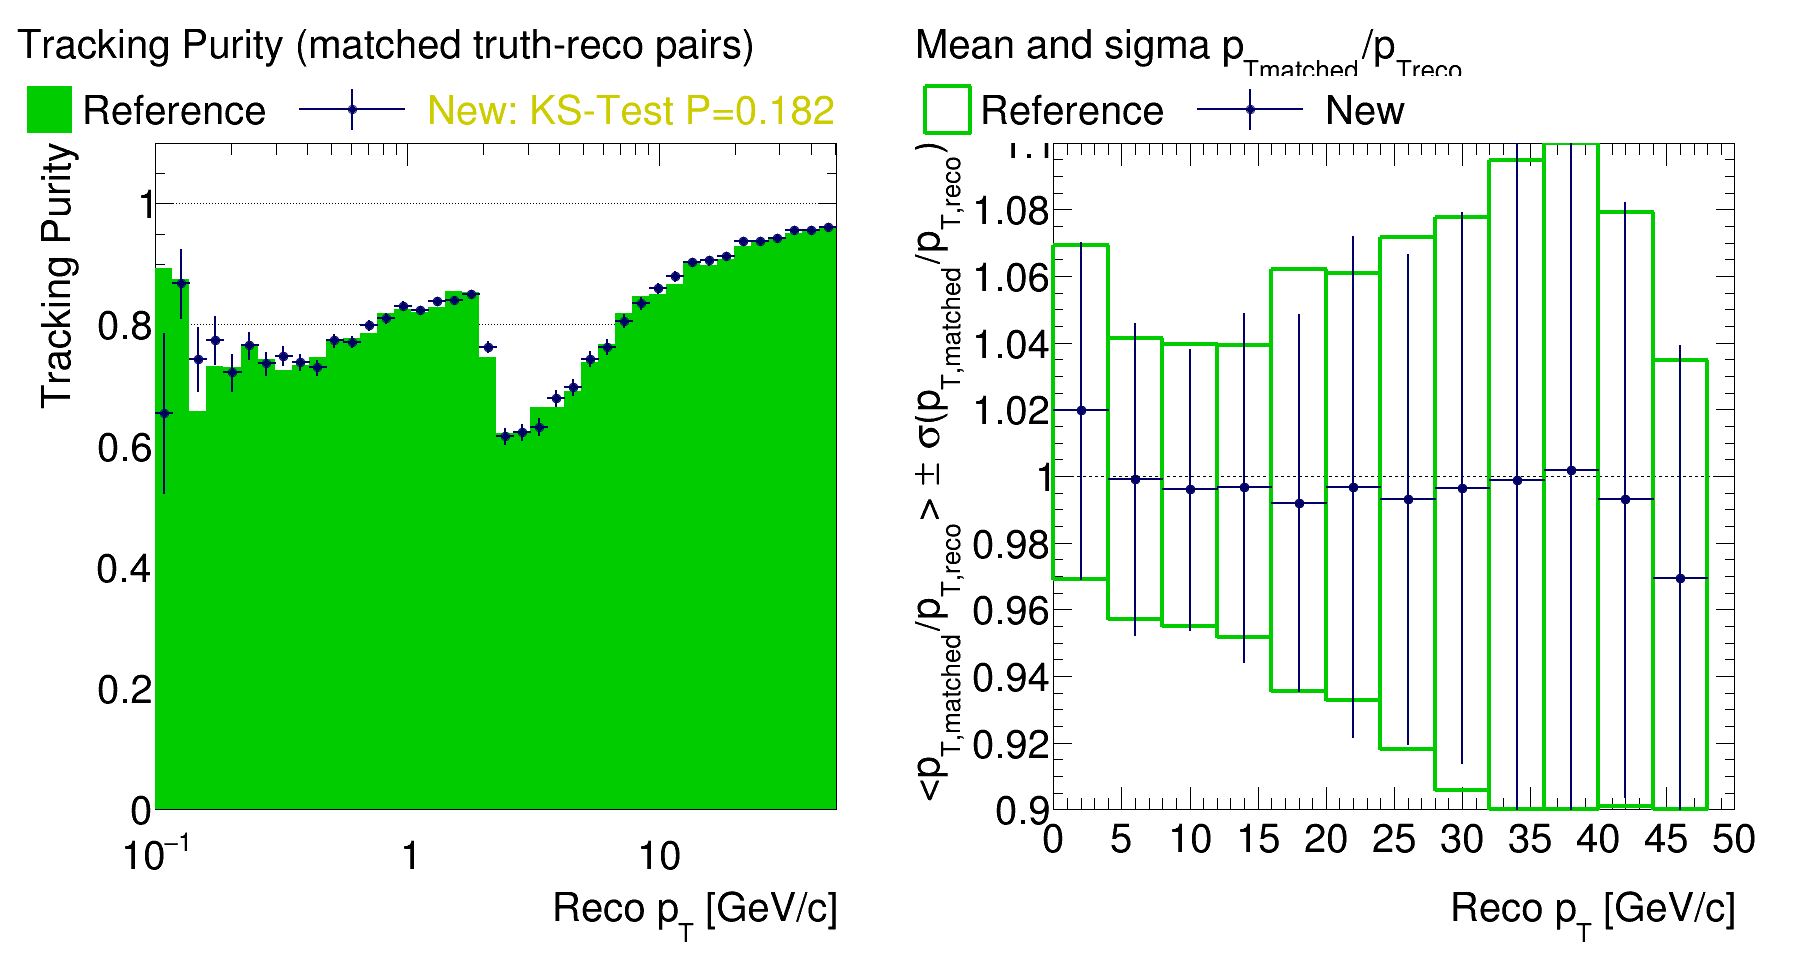

In [15]:
%%cpp

{
const char *hist_name_prefix = "QAG4SimulationTracking";
    TString prefix = TString("h_") + hist_name_prefix + TString("_");
    
    
  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;

  if (qa_file_new)
  {
    //cout << "Open new QA file " << qa_file_new->GetName() << endl;

    TH1 *h_norm = (TH1 *) qa_file_new->GetObjectChecked(
        prefix + TString("Normalization"), "TH1");
    assert(h_norm);

    Nevent_new = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }
  if (qa_file_ref)
  {
   // cout << "Open ref QA file " << qa_file_ref->GetName() << endl;
    TH1 *h_norm = (TH1 *) qa_file_ref->GetObjectChecked(
        prefix + TString("Normalization"), "TH1");
    assert(h_norm);

    Nevent_ref = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }
    
    
  TCanvas *c1 = new TCanvas(TString("QA_Draw_Tracking_RecoTruthMatching") +
                                TString("_") + hist_name_prefix,
                            TString("QA_Draw_Tracking_RecoTruthMatching") +
                                TString("_") + hist_name_prefix,
                            1800, 1000);
  c1->Divide(2, 1);
  int idx = 1;
  TPad *p;

  {
    static const int nrebin = 5;

    p = (TPad *) c1->cd(idx++);
    c1->Update();
    p->SetLogx();
    p->SetGridy();

    TH1 *h_pass =
        (TH1 *) qa_file_new->GetObjectChecked(prefix + "nGen_pTReco", "TH1");
    TH1 *h_norm =
        (TH1 *) qa_file_new->GetObjectChecked(prefix + "nReco_pTReco", "TH1");
    assert(h_norm);
    assert(h_pass);
      
      h_norm->SetDirectory(nullptr);
      h_pass->SetDirectory(nullptr);

    h_norm->Rebin(nrebin);
    h_pass->Rebin(nrebin);

    TH1 *h_ratio = GetBinominalRatio(h_pass, h_norm);

    //    h_ratio->GetXaxis()->SetRangeUser(min_Et, max_Et);
    h_ratio->GetYaxis()->SetTitle("Tracking Purity");
    h_ratio->GetYaxis()->SetRangeUser(-0, 1.1);

    TH1 *h_ratio_ref = NULL;
    if (qa_file_ref)
    {
      TH1 *h_pass =
          (TH1 *) qa_file_ref->GetObjectChecked(prefix + "nGen_pTReco", "TH1");
      TH1 *h_norm =
          (TH1 *) qa_file_ref->GetObjectChecked(prefix + "nReco_pTReco", "TH1");
      assert(h_norm);
      assert(h_pass);
      h_norm->SetDirectory(nullptr);
      h_pass->SetDirectory(nullptr);
      h_norm->Rebin(nrebin);
      h_pass->Rebin(nrebin);
      h_ratio_ref = GetBinominalRatio(h_pass, h_norm);
    }

    h_ratio->SetTitle("Tracking Purity (matched truth-reco pairs)");

    DrawReference(h_ratio, h_ratio_ref, false);
  }

  {
    p = (TPad *) c1->cd(idx++);
    c1->Update();
    //    p->SetLogx();
    TH1 *frame = p->DrawFrame(0, .9, 50, 1.1,
                              "Mean and sigma p_{Tmatched}/p_{Treco};Reco p_{T} [GeV/c];<p_{T,matched}/p_{T,reco}> #pm #sigma(p_{T,matched}/p_{T,reco})");
    // gPad->SetLeftMargin(.2);
    gPad->SetTopMargin(-1);
    frame->GetYaxis()->SetTitleOffset(1.7);
    // TLine *l = new TLine(0, 1, 50, 1);
    // l->SetLineColor(kGray);
    // l->Draw();
    HorizontalLine(gPad, 1)->Draw();

    TH2 *h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco =
        (TH2 *) qa_file_new->GetObjectChecked(
            prefix + "pTRecoTruthMatchedRatio_pTReco", "TH2");
    assert(h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco);

      h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->SetDirectory(nullptr);
    h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->Rebin2D(16, 1);

    TGraphErrors *ge_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco =
        FitProfile(h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco);
    ge_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->Draw("pe");
    ge_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->SetTitle(
        "Mean and sigma p_{Tmatched}/p_{Treco}");

    TGraphErrors *h_ratio_ref = NULL;
    if (qa_file_ref)
    {
      TH2 *h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco =
          (TH2 *) qa_file_ref->GetObjectChecked(
              prefix + "pTRecoTruthMatchedRatio_pTReco", "TH2");
      assert(h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco);

      h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->SetDirectory(nullptr);
      h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->Rebin2D(16, 1);

      h_ratio_ref =
          FitProfile(h_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco);
      ge_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco->Draw("pe");
    }

    DrawReference(ge_QAG4SimulationTracking_pTRecoTruthMatchedRatio_pTReco,
                  h_ratio_ref, true);
  }

    c1->Draw();
}

# Tracker hit checks

Hits per tracker and layer

## Number of clusters per tracker

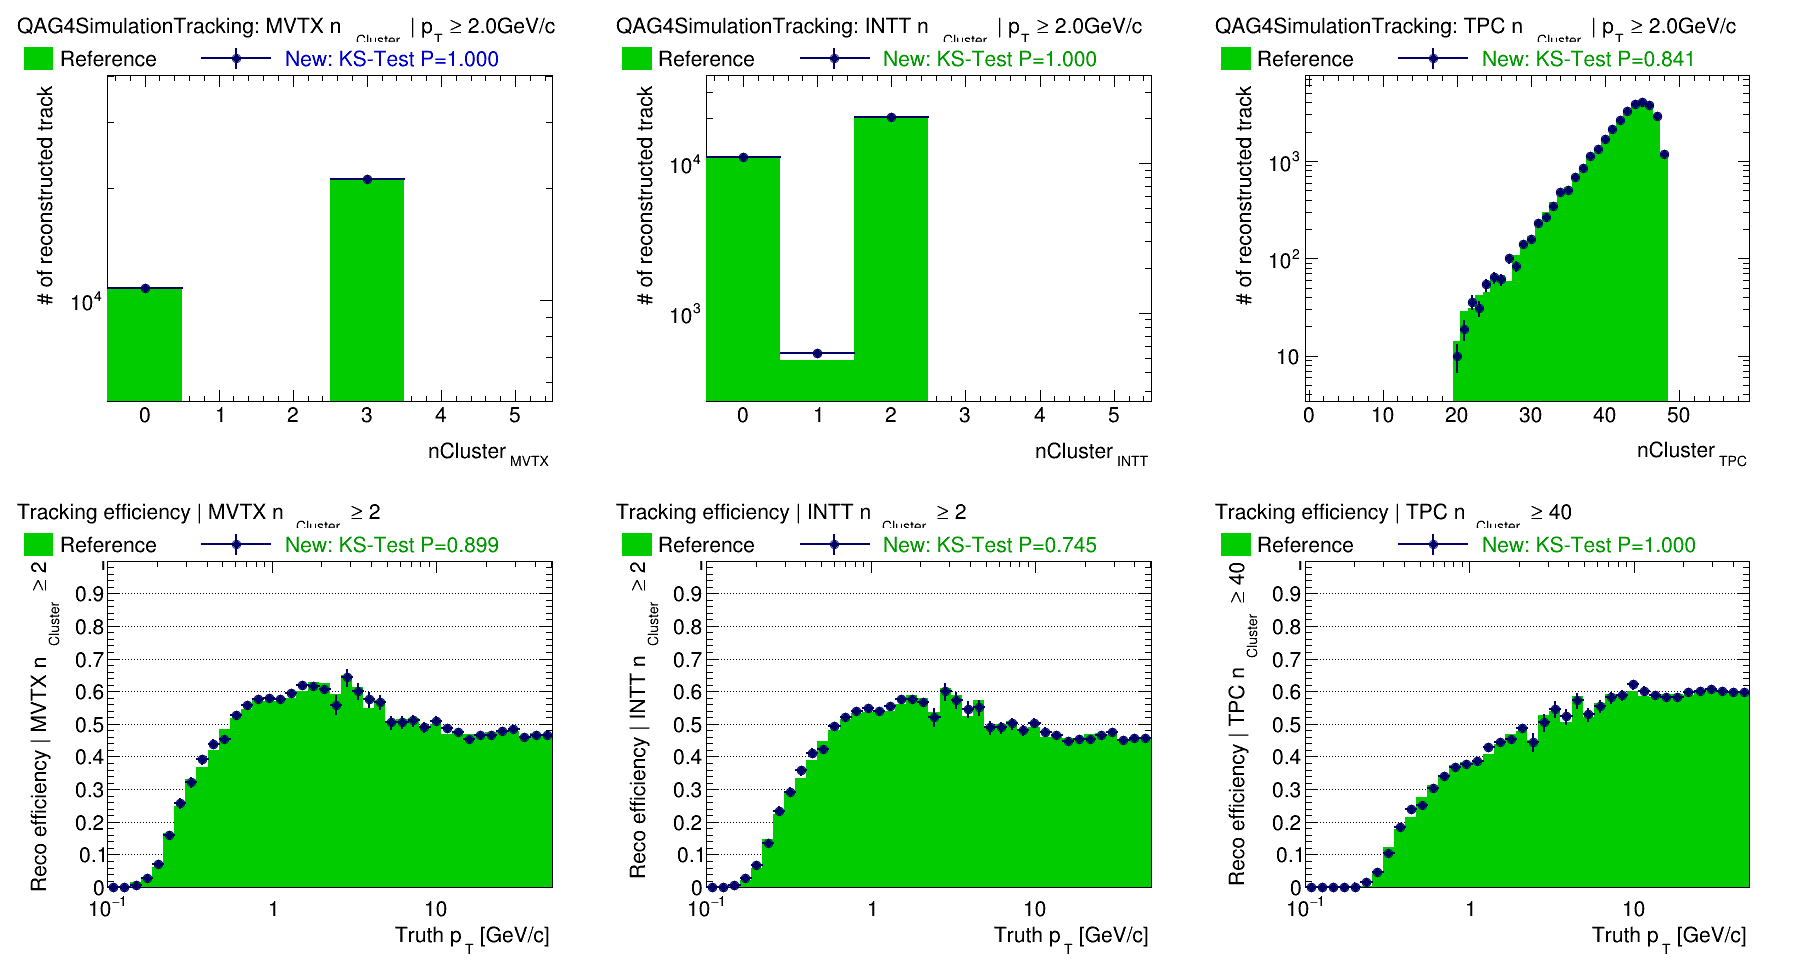

In [16]:
%%cpp
{
    const char *hist_name_prefix = "QAG4SimulationTracking";
      TString prefix = TString("h_") + hist_name_prefix + TString("_");

  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;
    
    

  if (qa_file_new)
  {
    TH1 *h_norm = (TH1 *) qa_file_new->GetObjectChecked(
        prefix + TString("Normalization"), "TH1");
    assert(h_norm);

    Nevent_new = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }
  if (qa_file_ref)
  {
    TH1 *h_norm = (TH1 *) qa_file_ref->GetObjectChecked(
        prefix + TString("Normalization"), "TH1");
    assert(h_norm);

    Nevent_ref = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }

  //MVTX, INTT, TPC
  vector<TString> detectors{"MVTX", "INTT", "TPC"};
  vector<int> eff_ncluster_cuts{2, 2, 40};
  vector<double> ncluster_spectrum_pt_cuts{2, 2, 2};
  vector<TH2 *> h_pass_detectors(3, nullptr);
  static const int nrebin = 5;

  h_pass_detectors[0] = (TH2 *) qa_file_new->GetObjectChecked(
      prefix + "nMVTX_nReco_pTGen", "TH1") ;
  h_pass_detectors[1] = (TH2 *) qa_file_new->GetObjectChecked(
      prefix + "nINTT_nReco_pTGen", "TH1") ;
  h_pass_detectors[2] = (TH2 *) qa_file_new->GetObjectChecked(
      prefix + "nTPC_nReco_pTGen", "TH1") ;

  TH1 *h_norm = (TH1 *) qa_file_new->GetObjectChecked(
      prefix + "nGen_pTGen", "TH1") ;
  assert(h_norm);
    h_norm->SetDirectory(nullptr);
  h_norm->Rebin(nrebin);

  vector<TH2 *> h_pass_detectors_ref(3, nullptr);
  TH1 *h_norm_ref = nullptr;
  if (qa_file_ref)
  {
    h_pass_detectors_ref[0] = (TH2 *) qa_file_ref->GetObjectChecked(
        prefix + "nMVTX_nReco_pTGen", "TH1") ;
    h_pass_detectors_ref[1] = (TH2 *) qa_file_ref->GetObjectChecked(
        prefix + "nINTT_nReco_pTGen", "TH1") ;
    h_pass_detectors_ref[2] = (TH2 *) qa_file_ref->GetObjectChecked(
        prefix + "nTPC_nReco_pTGen", "TH1") ;

    h_norm_ref = (TH1 *) qa_file_ref->GetObjectChecked(
        prefix + "nGen_pTGen", "TH1") ;
    h_norm_ref->SetDirectory(nullptr);
    h_norm_ref->Rebin(nrebin);

  }

  TCanvas *c1 = new TCanvas(TString("QA_Draw_Tracking_TruthMatching_NumOfClusters") + TString("_") + hist_name_prefix,
                            TString("QA_Draw_Tracking_TruthMatching_NumOfClusters") + TString("_") + hist_name_prefix,
                            1800, 1000);
  c1->Divide(3, 2);
  TPad *p;

  for (int i = 0; i < 3; ++i)
  {
    TString detector = detectors[i];
    TH2 *h_pass_detector = h_pass_detectors[i];
    TH2 *h_pass_detector_ref = h_pass_detectors_ref[i];
    assert(h_pass_detector);

    {
      p = (TPad *) c1->cd(i + 1);
      c1->Update();
      p->SetLogy();

      const int bin_start = h_pass_detector->GetXaxis()->FindBin(ncluster_spectrum_pt_cuts[i]);

      TH1 *h_pass_detector_ncluster = h_pass_detector->ProjectionY(
          TString(h_pass_detector->GetName()) + "_nCluster_new",
          bin_start);
      TH1 *h_pass_detector_ncluster_ref = nullptr;
      if (h_pass_detector_ref)
      {
        h_pass_detector_ncluster_ref = h_pass_detector_ref->ProjectionY(
            TString(h_pass_detector_ref->GetName()) + "_nCluster_ref",
            bin_start);
      }

      h_pass_detector_ncluster->SetTitle(TString(hist_name_prefix) + ": " + detector + Form(" n_{Cluster} | p_{T} #geq %.1fGeV/c", ncluster_spectrum_pt_cuts[i]));
      h_pass_detector_ncluster->SetYTitle("# of reconstructed track");
      DrawReference(h_pass_detector_ncluster, h_pass_detector_ncluster_ref, false);
    }

    {
      p = (TPad *) c1->cd(i + 3 + 1);
      c1->Update();
      p->SetLogx();
      p->SetGridy();

      const int bin_start = h_pass_detector->GetYaxis()->FindBin(eff_ncluster_cuts[i]);
      TH1 *h_pass = h_pass_detector->ProjectionX(
          TString(h_pass_detector->GetName()) + "_nReco_new",
          bin_start);

      assert(h_pass);
        h_pass->SetDirectory(nullptr);
      h_pass->Rebin(nrebin);

      TH1 *h_ratio = GetBinominalRatio(h_pass, h_norm);
      h_ratio->GetYaxis()->SetTitle("Reco efficiency | " + detector + Form(" n_{Cluster} #geq %d", eff_ncluster_cuts[i]));
      h_ratio->GetYaxis()->SetRangeUser(-0, 1.);
      //
      TH1 *h_ratio_ref = NULL;
      if (h_pass_detector_ref)
      {
        TH1 *h_pass = h_pass_detector_ref->ProjectionX(
            TString(h_pass_detector->GetName()) + "_nReco_ref",
            bin_start);

        assert(h_pass);
        h_pass->SetDirectory(nullptr);
      h_pass->Rebin(nrebin);

        h_ratio_ref = GetBinominalRatio(h_pass, h_norm_ref);
      }
      //
      h_ratio->SetTitle("Tracking efficiency | " + detector + Form(" n_{Cluster} #geq %d", eff_ncluster_cuts[i]));
      DrawReference(h_ratio, h_ratio_ref, false);
    }
  }

  // SaveCanvas(c1, TString(qa_file_name_new) + TString("_") + TString(c1->GetName()), true);
    c1->Draw();
}

## Hits per layer

In [17]:
%%cpp -d


namespace
{
  // Normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;

  void GetNormalization(TFile *qa_file_new, TFile *qa_file_ref, const TString &prefix, const TString &tag)
  {
    if (qa_file_new)
    {
      TH1 *h_norm = (TH1 *) qa_file_new->GetObjectChecked(prefix + TString("Normalization"), "TH1");
      assert(h_norm);
      Nevent_new = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin(tag));
    }

    if (qa_file_ref)
    {
      TH1 *h_norm = (TH1 *) qa_file_ref->GetObjectChecked(prefix + TString("Normalization"), "TH1");
      assert(h_norm);
      Nevent_ref = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin(tag));
    }
  }

  void Draw(TFile *qa_file_new, TFile *qa_file_ref, const TString &prefix, const TString &tag)
  {
    auto h_new = static_cast<TH1 *>(qa_file_new->GetObjectChecked(prefix + tag, "TH1"));
    assert(h_new);
    //h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1 *h_ref = nullptr;
    if (qa_file_ref)
    {
      h_ref = static_cast<TH1 *>(qa_file_ref->GetObjectChecked(prefix + tag, "TH1"));
      assert(h_ref);
      //h_ref->Sumw2();
      h_ref->Scale(1.0 / Nevent_ref);
    }

    DrawReference(h_new, h_ref);
    HorizontalLine(gPad, 1)->Draw();
  }

}  // namespace

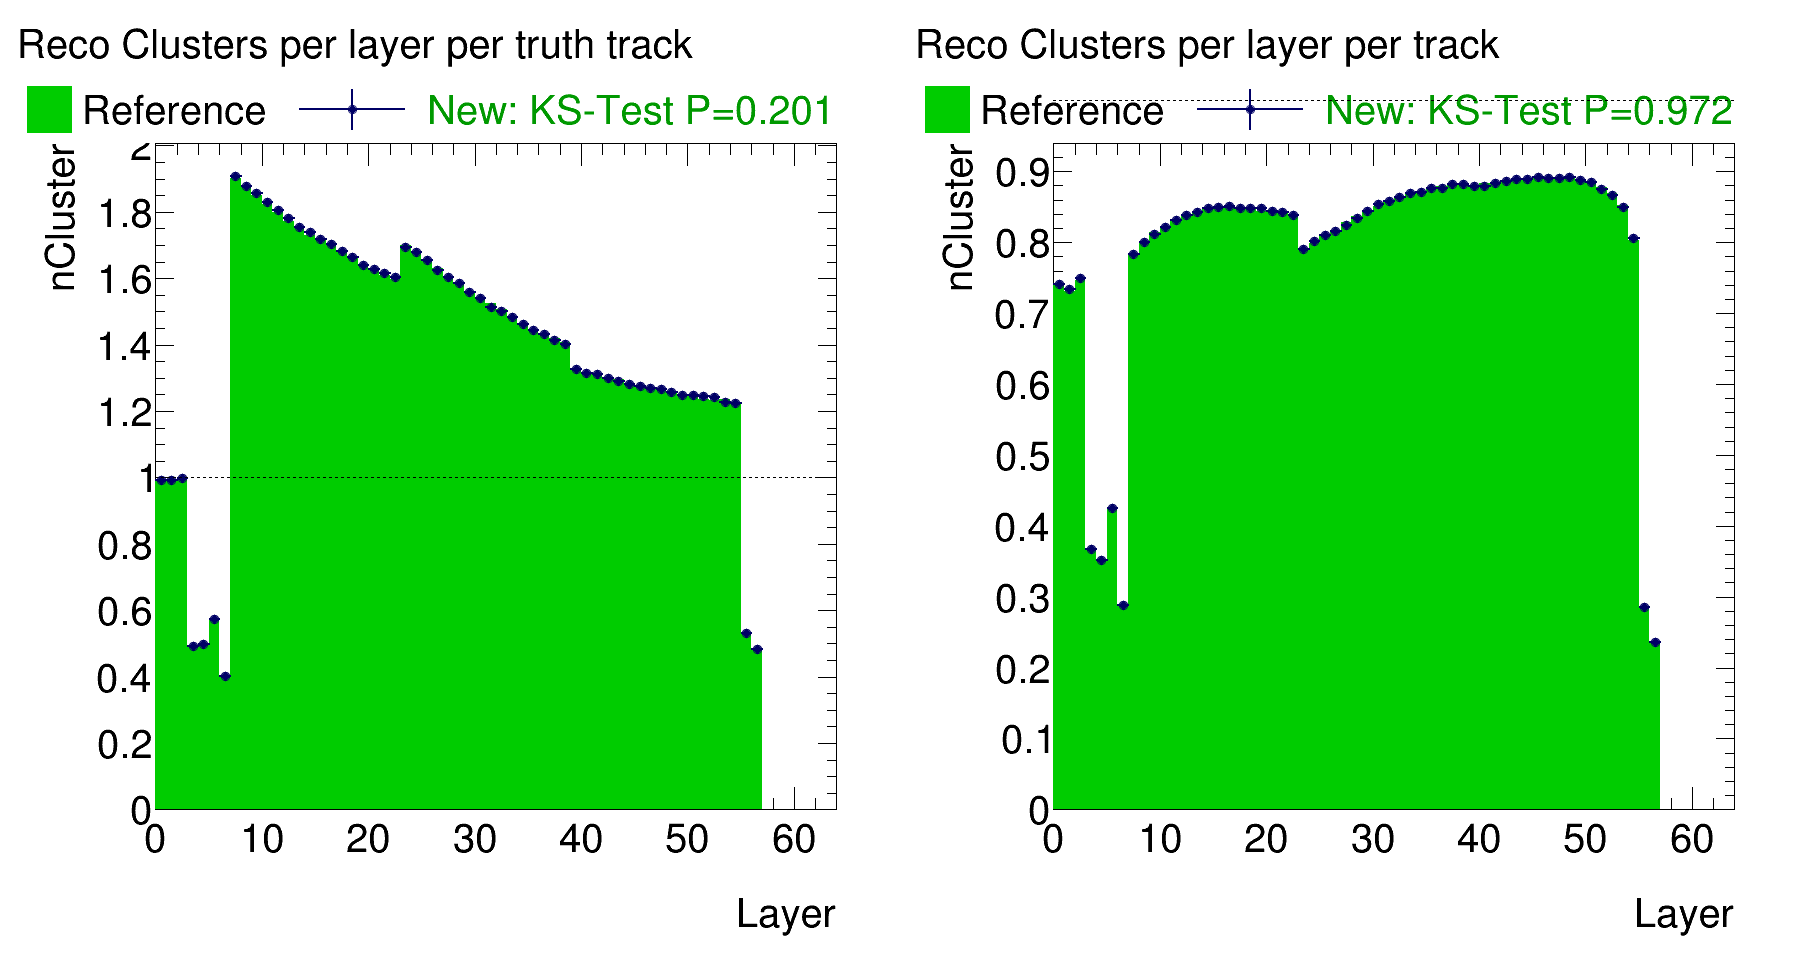

In [18]:
%%cpp
{
     const char *hist_name_prefix = "QAG4SimulationTracking";
      TString prefix = TString("h_") + hist_name_prefix + TString("_");

  auto c1 = new TCanvas(TString("QA_Draw_Tracking_nClus_Layer") + TString("_") + hist_name_prefix,
                        TString("QA_Draw_Tracking_nClus_Layer") + TString("_") + hist_name_prefix,
                        1800, 1000);

  c1->Divide(2, 1);
  c1->cd(1);
  GetNormalization(qa_file_new, qa_file_ref, prefix, "Truth Track");
  Draw(qa_file_new, qa_file_ref, prefix, "nClus_layerGen");

  c1->cd(2);
  GetNormalization(qa_file_new, qa_file_ref, prefix, "Reco Track");
  Draw(qa_file_new, qa_file_ref, prefix, "nClus_layer");

  // SaveCanvas(c1, TString(qa_file_name_new) + TString("_") + TString(c1->GetName()), true);
    c1->Draw();
}

# Upsilon reconstruction

One $\Upsilon(1S) \rightarrow e^+ e^-$ is embedded. Here is its reco results

In [19]:
%%cpp -d

// square
inline double square( const double& x ) { return x*x; }

// christal ball function for momentum resolution fit
Double_t CBcalc(Double_t *xx, Double_t *par)
{
  // Crystal Ball fit to one state
  double f;
  const double x = xx[0];

  // The four parameters (alpha, n, x_mean, sigma) plus normalization (N) are:
   
  const double alpha = par[0];
  const double n = par[1];
  const double x_mean = par[2];
  const double sigma = par[3];
  const double N = par[4];

  // dimensionless variable
  const double t = (x-x_mean)/sigma;

  // The Crystal Ball function is:
   
  if( t > -alpha)
  {
    return N * exp( -square(t)/2 );
  }
  else
  {
    const double A = pow( (n/TMath::Abs(alpha)),n) * exp(-square(alpha)/2.0);
    const double B = n/TMath::Abs(alpha) - TMath::Abs(alpha);
    return N * A * pow(B - t, -n);
  }

}

// christal ball function for Upsilon fits
Double_t CBcalc2(Double_t *xx, Double_t *par)
{
  // Crystal Ball fit to one state
  const double x = xx[0];

  /* The parameters are: 
   * N the normalization
   * x_mean, sigma
   * alpha_left, n_left
   * alpha_right, n_right
   */
  const double N = par[0];
  const double x_mean = par[1];
  const double sigma = par[2];
  const double t = (x-x_mean)/sigma;    

  // left tail
  const double alpha_left = std::abs(par[3]);
  const double n_left = par[4];

  // right tail
  const double alpha_right = std::abs(par[5]);
  const double n_right = par[6];
    
  // The Crystal Ball function is:   
  if( t < -alpha_left )
  {      
    const double A = pow( (n_left/TMath::Abs(alpha_left)),n_left) * exp(-square(alpha_left)/2.0);
    const double B = n_left/std::abs(alpha_left) - std::abs(alpha_left);
    return N * A * pow(B - t, -n_left);
  } else if( t > alpha_right ) {
     const double A = pow( (n_right/TMath::Abs(alpha_right)),n_right) * exp(-square(alpha_right)/2.0);
     const double B = n_right/std::abs(alpha_right) - std::abs(alpha_right);
     return N * A * pow(B + t, -n_right);  
  } else {
      return N * exp( -square(t)/2);
  }
}


In [20]:
%%cpp

{
  const char *hist_name_prefix = "QAG4SimulationUpsilon";
  TString prefix = TString("h_") + hist_name_prefix + TString("_");

  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;

  if ( qa_file_new->GetObjectChecked(
        prefix + TString("pTRecoGenRatio_pTGen"), "TH2")
     == nullptr )
    {
        cout <<"QAG4SimulationUpsilon is not enabled. Skip...."<<endl;
    }
    else
    {

      TCanvas *c1 = new TCanvas(TString("QA_Draw_Tracking_UpsilonOverview") + TString("_") + hist_name_prefix,
                                TString("QA_Draw_Tracking_UpsilonOverview") + TString("_") + hist_name_prefix,
                                1800, 1000);
      c1->Divide(2, 1);
      int idx = 1;
      TPad *p;

      {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();

        TH2 *h_new = (TH2 *) qa_file_new->GetObjectChecked(
            prefix + TString("pTRecoGenRatio_pTGen"), "TH2");
        assert(h_new);

        //  h_new->Rebin(1, 2);
        //h_new->Sumw2();
        //  h_new->Scale(1. / Nevent_new);

        TH2 *h_ref = NULL;
        if (qa_file_ref)
        {
          h_ref = (TH2 *) qa_file_ref->GetObjectChecked(
              prefix + TString("pTRecoGenRatio_pTGen"), "TH2");
          assert(h_ref);

          //    h_ref->Rebin(1, 2);
          //h_ref->Sumw2();
          h_ref->Scale(Nevent_new / Nevent_ref);
        }

        TH1 *h_proj_new = h_new->ProjectionY(
            TString::Format(
                "%s_New_ProjX",
                h_new->GetName()));

        h_proj_new->GetXaxis()->SetRangeUser(0, 1.3);
        h_proj_new->SetTitle(TString(hist_name_prefix) + TString::Format(
                                                             ": Electron lineshape"));
        h_proj_new->GetXaxis()->SetTitle(TString::Format(
            "Reco p_{T}/Truth p_{T}"));

        TF1 *f_eLineshape = new TF1("f_eLineshape", CBcalc, 7, 11, 5);
        f_eLineshape->SetParameter(0, 1.0);
        f_eLineshape->SetParameter(1, 1.0);
        f_eLineshape->SetParameter(2, 0.95);
        f_eLineshape->SetParameter(3, 0.08);
        f_eLineshape->SetParameter(4, 20.0);

        f_eLineshape->SetParNames("alpha","n","m","sigma","N");
        f_eLineshape->SetLineColor(kRed);
        f_eLineshape->SetLineWidth(3);
        f_eLineshape->SetLineStyle(kSolid);
        f_eLineshape->SetNpx(1000);

        h_proj_new->Fit(f_eLineshape);

        TH1 *h_proj_ref = nullptr;
        if (h_ref)
        {
          h_proj_ref =
              h_ref->ProjectionY(
                  TString::Format(
                      "%s_Ref_ProjX",
                      h_new->GetName()));
        }
        TF1 *f_eLineshape_ref = new TF1("f_eLineshape_ref", CBcalc, 7, 11, 5);
        f_eLineshape_ref->SetParameter(0, 1.0);
        f_eLineshape_ref->SetParameter(1, 1.0);
        f_eLineshape_ref->SetParameter(2, 0.95);
        f_eLineshape_ref->SetParameter(3, 0.08);
        f_eLineshape_ref->SetParameter(4, 20.0);

        f_eLineshape_ref->SetParNames("alpha","n","m","sigma","N");
        f_eLineshape_ref->SetLineColor(kRed);
        f_eLineshape_ref->SetLineWidth(3);
        f_eLineshape_ref->SetLineStyle(kSolid);

        h_proj_ref->Fit(f_eLineshape_ref);


        DrawReference(h_proj_new, h_proj_ref);
        f_eLineshape->Draw("same");

        char resstr_1[500];
        sprintf(resstr_1,"#sigma_{dp/p} = %.2f #pm %.2f %%", f_eLineshape->GetParameter(3)*100, f_eLineshape->GetParError(3)*100);
        TLatex *res_1 = new TLatex(0.2,0.75,resstr_1);
        res_1->SetNDC();
        res_1->SetTextSize(0.05);
        res_1->SetTextAlign(13);
        res_1->Draw();

        char resstr_2[500];
        sprintf(resstr_2,"#sigma_{dp/p,ref} = %.2f #pm %.2f %%", f_eLineshape_ref->GetParameter(3)*100, f_eLineshape_ref->GetParError(3)*100);
        TLatex *res_2 = new TLatex(0.2,0.7,resstr_2);
        res_2->SetNDC();
        res_2->SetTextSize(0.05);
        res_2->SetTextAlign(13);
        res_2->Draw();
      }

      {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
    //    p->SetLogy();

        TH1 *h_new = (TH1 *) qa_file_new->GetObjectChecked(
            prefix + TString("nReco_Pair_InvMassReco"), "TH1");
        assert(h_new);

        // h_new->Rebin(2);
        // h_new->Sumw2();
        // h_new->Scale(1. / Nevent_new);

        TF1 *f1S = new TF1("f1S", CBcalc2, 7, 11, 7);
        f1S->SetParameter(0, 50.0);
        f1S->SetParameter(1, 9.46);
        f1S->SetParameter(2, 0.08);
        f1S->SetParameter(3, 1.0);
        f1S->SetParameter(4, 3.0);
        f1S->SetParameter(5, 1.0);
        f1S->SetParLimits(3, 0.120, 10);
        f1S->SetParLimits(4, 1.05, 10);
        f1S->SetParameter(6, 3.0);
        f1S->SetParLimits(5, 0.120, 10);
        f1S->SetParLimits(6, 1.05, 10);
 
        f1S->SetParNames("N", "m", "#sigma", "#alpha_{left}","n_{left}","#alpha_{right}","#sigma_{right}");
        f1S->SetLineColor(kRed);
        f1S->SetLineWidth(3);
        f1S->SetLineStyle(kSolid);
        f1S->SetNpx(1000);

        h_new->Fit(f1S);

        TH1 *h_ref = NULL;
        if (qa_file_ref)
        {
          h_ref = (TH1 *) qa_file_ref->GetObjectChecked(
              prefix + TString("nReco_Pair_InvMassReco"), "TH1");
          assert(h_ref);

          // h_ref->Rebin(2);
          // h_ref->Sumw2();
          // h_ref->Scale(Nevent_new / Nevent_ref);
        }

        h_new->SetTitle(TString(hist_name_prefix) + TString::Format(
                                                        ": #Upsilon #rightarrow e^{+}e^{-} lineshape"));
        h_new->GetXaxis()->SetRangeUser(7, 10);

        TF1 *f1S_ref = new TF1("f1S_ref", CBcalc2, 7, 11, 7);
        f1S_ref->SetParameter(0, 50.0);
        f1S_ref->SetParameter(1, 9.46);
        f1S_ref->SetParameter(2, 0.08);
        f1S_ref->SetParameter(3, 1.0);
        f1S_ref->SetParameter(4, 3.0);
        f1S_ref->SetParameter(5, 1.0);
        f1S_ref->SetParLimits(3, 0.120, 10);
        f1S_ref->SetParLimits(4, 1.05, 10);
        f1S_ref->SetParameter(6, 3.0);
        f1S_ref->SetParLimits(5, 0.120, 10);
        f1S_ref->SetParLimits(6, 1.05, 10);
 
        f1S_ref->SetParNames("N", "m", "#sigma", "#alpha_{left}","n_{left}","#alpha_{right}","#sigma_{right}");
        f1S_ref->SetLineColor(kRed);
        f1S_ref->SetLineWidth(3);
        f1S_ref->SetLineStyle(kSolid);

        h_ref->Fit(f1S_ref);

        DrawReference(h_new, h_ref, false);
        f1S->Draw("same");

        // cout << "f1S pars " <<  f1S->GetParameter(3) << "   " << f1S->GetParError(3) << endl;

        char resstr_3[500];
        sprintf(resstr_3,"#sigma_{1S} = %.1f #pm %.1f MeV", f1S->GetParameter(2)*1000, f1S->GetParError(2)*1000);
        TLatex *res_3 = new TLatex(0.2,0.75,resstr_3);
        res_3->SetNDC();
        res_3->SetTextSize(0.05);
        res_3->SetTextAlign(13);
        res_3->Draw();

        char resstr_4[500];
        sprintf(resstr_4,"#sigma_{1S,ref} = %.1f #pm %.1f MeV", f1S_ref->GetParameter(2)*1000, f1S_ref->GetParError(2)*1000);
        TLatex *res_4 = new TLatex(0.2,0.7,resstr_4);
        res_4->SetNDC();
        res_4->SetTextSize(0.05);
        res_4->SetTextAlign(13);
        res_4->Draw();
      }

      // SaveCanvas(c1, TString(qa_file_name_new) + TString("_") + TString(c1->GetName()), true);

      c1 -> Draw();
    }// if checks
}

QAG4SimulationUpsilon is not enabled. Skip....


# Summary statistics

In [21]:
%%cpp

KSTestSummary::getInstance()->make_summary_txt("QA-tracking.txt");

This notebook contains 19 KSTets: combined Chi2/nDoF = 23.5238 / 38, and combined __p-Value = 0.968312__


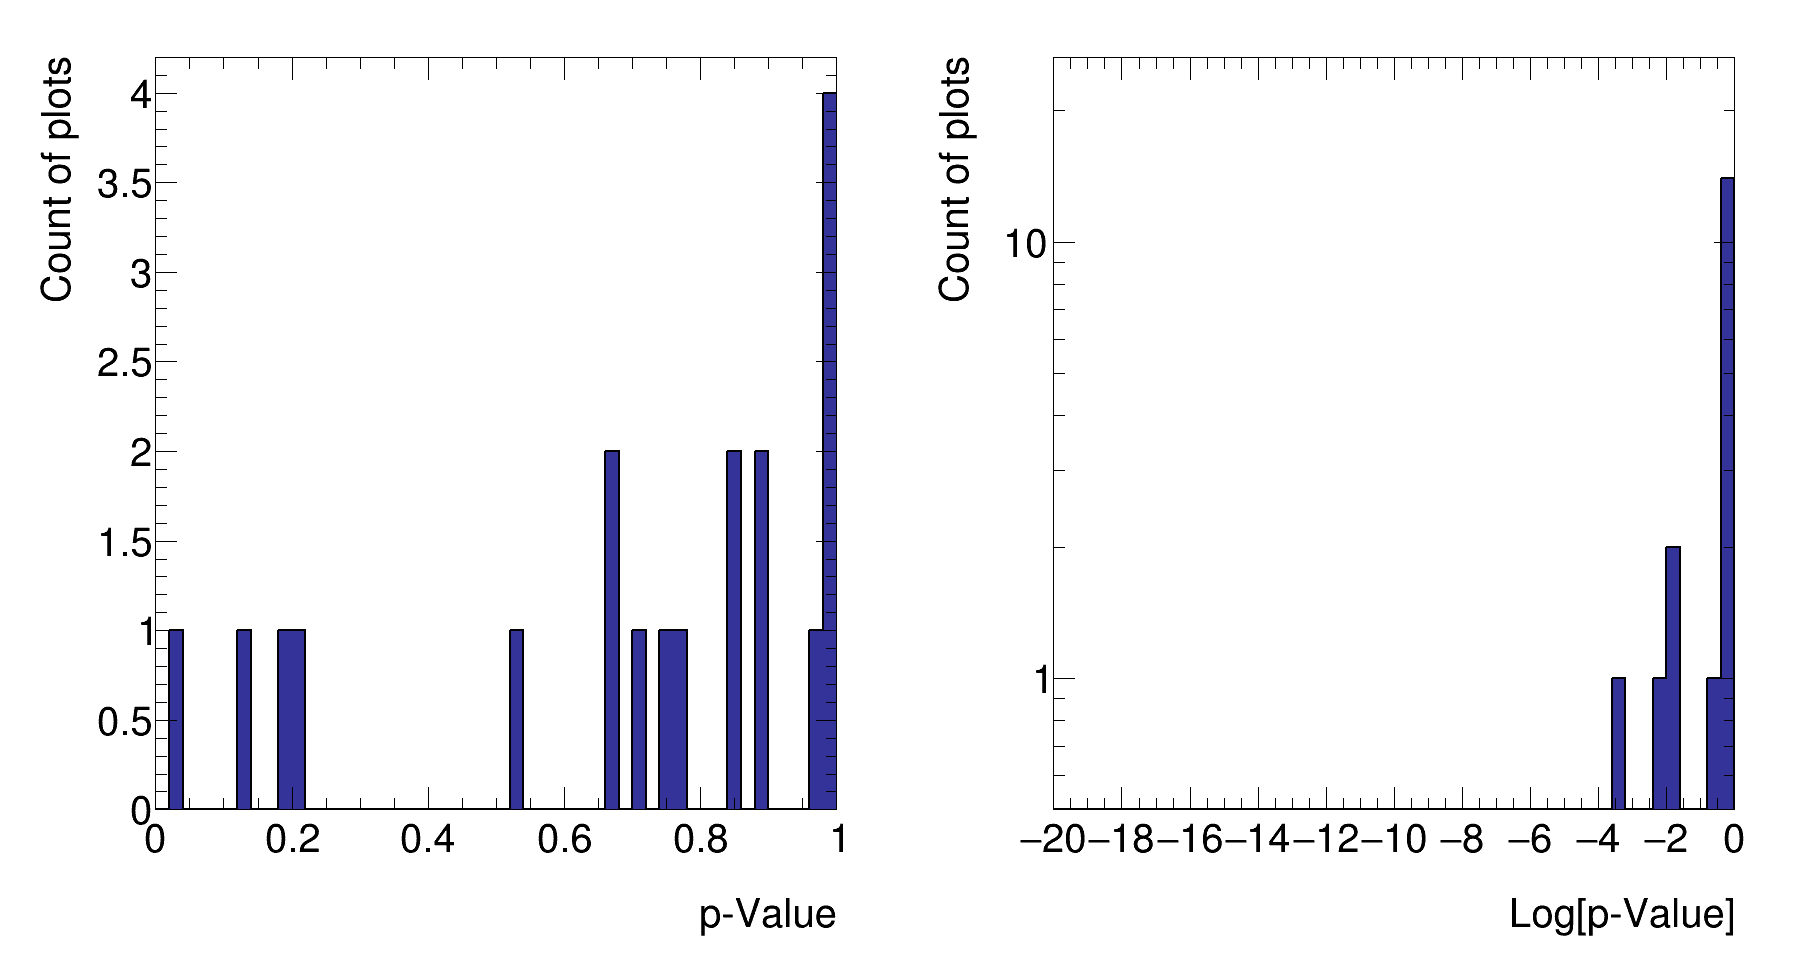

In [22]:
%%cpp

KSTestSummary::getInstance()->make_summary_TCanvas() -> Draw();